# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

In [1]:
import sys; sys.path.append("..")
import numpy as np
from utils.optimization import gd, sgd
import matplotlib.pyplot as plt
import scipy

np.random.seed(42)

## Dataset creation

In [2]:
def generalizedVander(funcs, x):
    V = np.zeros((len(x), len(funcs)))
    for j, fn in enumerate(funcs):
        V[:, j] = fn(np.array(x))
    return V

def Phi(X, K):
    return generalizedVander([ (lambda x, coef=j: x**coef) for j in range(K) ], X)


def createDataset(N, a, b, K, theta_true, variance, random_seed=42):
    X_full = np.linspace(a, b, N)
    Y_full = Phi(X_full, K) @ theta_true + np.random.default_rng(random_seed).normal(0, np.sqrt(variance), N)
    return X_full, Y_full

def train_test_split(X, Y, train_size, random_seed=42):
    idxs = np.arange(0, X.shape[0])
    np.random.default_rng(random_seed).shuffle(idxs)
    X_train = X[idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

In [3]:
N = 1500
K = 4
a, b = -1, 1
variance = 0.1
theta_true = np.ones(K)

X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

# X_train, Y_train = createDataset(N, -1, 0.5, K, theta_true, variance)
# X_test, Y_test = createDataset(N, 0.5, 1, K, theta_true, variance)


print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1125,)
Test shape: (375,)


## Evaluation utilities

In [4]:
def avgAbsoluteError(model, X, Y):
    assert model.predict(X).shape == Y.shape
    return (1/Y.shape[0]) * (np.linalg.norm(model.predict(X) - Y, 2)**2)

def thetaError(model, theta_true):
    padded_theta = np.zeros(model.theta.shape)
    padded_theta[:theta_true.shape[0]] = theta_true
    assert model.theta.shape == padded_theta.shape
    return np.linalg.norm(model.theta - padded_theta, 2) / np.linalg.norm(padded_theta, 2)

In [5]:
def plotDataForVaryingK(model, X_train, Y_train, X_test, Y_test, real_K, K_variation=3, theta_true=None, fig_size=(18, 6)):
    to_test_K = [*range(max(1, real_K-K_variation), real_K)] + [real_K] + [*range(real_K+1, real_K+K_variation+1)]
    train_errors = []
    test_errors = []
    plot_X = np.linspace(a, b, 10000)
    
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    plt.title("Datapoints")
    plt.plot(X_train, Y_train, ".", alpha=0.15, label="Train data")
    plt.plot(X_test, Y_test, ".", alpha=0.15, label="Test data")
    plt.plot(plot_X, Phi(plot_X, real_K) @ theta_true, "--", label="Ideal")
    
    for K in to_test_K:
        model.K = K
        model.fit(X_train, Y_train, epochs=1000)
        train_errors.append( avgAbsoluteError(model, X_train, Y_train) )
        test_errors.append( avgAbsoluteError(model, X_test, Y_test) )

        print(f"K={K} | Avg absolute error: [test] {test_errors[-1]:<20} | [train] {train_errors[-1]:<20}")
        plt.plot(plot_X, model.predict(plot_X), "-", label=f"K={K}", linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Average absolute errors")
    plt.plot(to_test_K, train_errors, label="Train")
    plt.plot(to_test_K, test_errors, label="Test")
    plt.xlabel("K")
    plt.xticks(to_test_K)
    plt.legend()
    plt.show()

## Maximum Likelihood Estimation

In [6]:
class Regressor:
    def __init__(self, K):
        self.theta = None
        self.K = K

    def _loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def _grad_loss(self, theta, Phi_X, Y):
        raise NotImplementedError()

    def fit(self, X, Y, batch_size=500, epochs=100, lr=3e-3):
        history_w, history_loss, history_grad, history_err = sgd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            batch_size = batch_size,
            n_epochs = epochs,
            lr = lr,
        )

        # print(f"Loss: {[round(h, 2) for h in history_loss]}")
        # print(f"Gradient norm: {[round(h, 2) for h in history_err]}")
        self.theta = history_w[-1]
        return self

    def fit_gd(self, X, Y, epochs=100, tol_loss=1e-6, tol_theta=1e-6):
        history_w, curr_k, history_loss, history_grad, history_err = gd(
            loss = self._loss, 
            grad_loss = self._grad_loss,
            w0 = np.zeros(self.K),
            data = (Phi(X, self.K).T, Y),
            k_max = epochs,
            tol_loss = tol_loss,
            tol_w = tol_theta,
            alpha = None
        )
        self.theta = history_w[-1]
        return self
        

    def predict(self, X):
        return Phi(X, self.K) @ self.theta

In [7]:
class MLERegressor(Regressor):
    def __init__(self, K):
        super().__init__(K)

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*np.linalg.norm(Y - (theta @ Phi_X))**2

    def _grad_loss(self, theta, Phi_X, Y):
        return -((Y.T @ Phi_X.T) - (theta.T @ Phi_X @ Phi_X.T))
    

    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor(Phi_X.T @ Phi_X), (Phi_X.T @ Y) )
        return self

K=1 | Avg absolute error: [test] 0.8871876647040573   | [train] 1.1449368178615156  
K=2 | Avg absolute error: [test] 0.1794188572613732   | [train] 0.2255456765179204  
K=3 | Avg absolute error: [test] 0.12737939530665993  | [train] 0.12263964564586749 
K=4 | Avg absolute error: [test] 0.1045223969580364   | [train] 0.09904628815074956 
K=5 | Avg absolute error: [test] 0.10449572206091488  | [train] 0.09904378485693847 
K=6 | Avg absolute error: [test] 0.10456912545244743  | [train] 0.09905085007747166 
K=7 | Avg absolute error: [test] 0.10450917141748724  | [train] 0.09907400155678361 


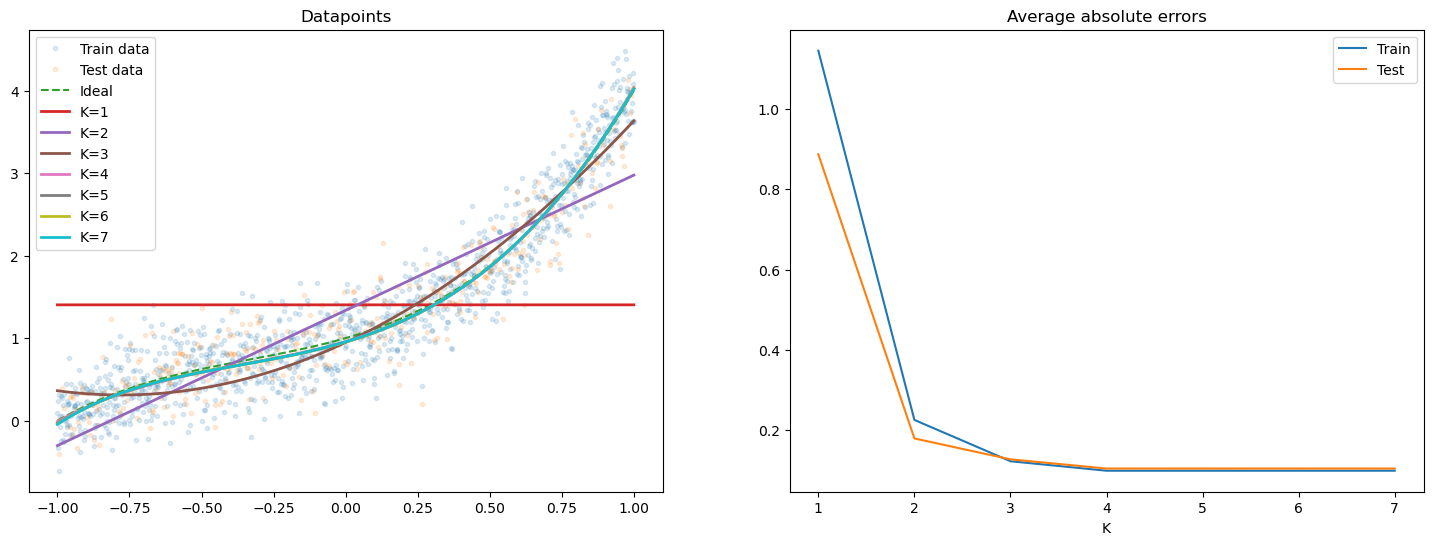

In [8]:
plotDataForVaryingK(MLERegressor(K=None), X_train, Y_train, X_test, Y_test, real_K=K, theta_true=theta_true)

## Maximum a Posteriori

### Fixed $\lambda$, varying $K$

In [9]:
class MAPRegressor(Regressor):
    def __init__(self, K, lamb):
        super().__init__(K)
        self.lamb = lamb

    def _loss(self, theta, Phi_X, Y):
        return (1/2)*(np.linalg.norm(Y - (theta @ Phi_X))**2) + (1/2)*(self.lamb*np.linalg.norm(theta, 2)**2)

    def _grad_loss(self, theta, Phi_X, Y):
        return -((Y.T @ Phi_X.T) - (theta.T @ Phi_X @ Phi_X.T)) + (self.lamb*theta)
    
    def fit_neq(self, X, Y):
        Phi_X = Phi(X, self.K)
        self.theta = scipy.linalg.cho_solve( scipy.linalg.cho_factor((Phi_X.T @ Phi_X) + (self.lamb*np.identity(Phi_X.shape[1]))), (Phi_X.T @ Y) )
        return self

>>>>> lambda = 0.1 <<<<<
K=2 | Avg absolute error: [test] 0.1792595575793017   | [train] 0.2255450699901999  
K=3 | Avg absolute error: [test] 0.12721625381705154  | [train] 0.12267245682573238 
K=4 | Avg absolute error: [test] 0.10441561012251012  | [train] 0.09906631604135    
K=5 | Avg absolute error: [test] 0.10435517619719217  | [train] 0.09906470917570355 
K=6 | Avg absolute error: [test] 0.10444355456174297  | [train] 0.09909245630383388 


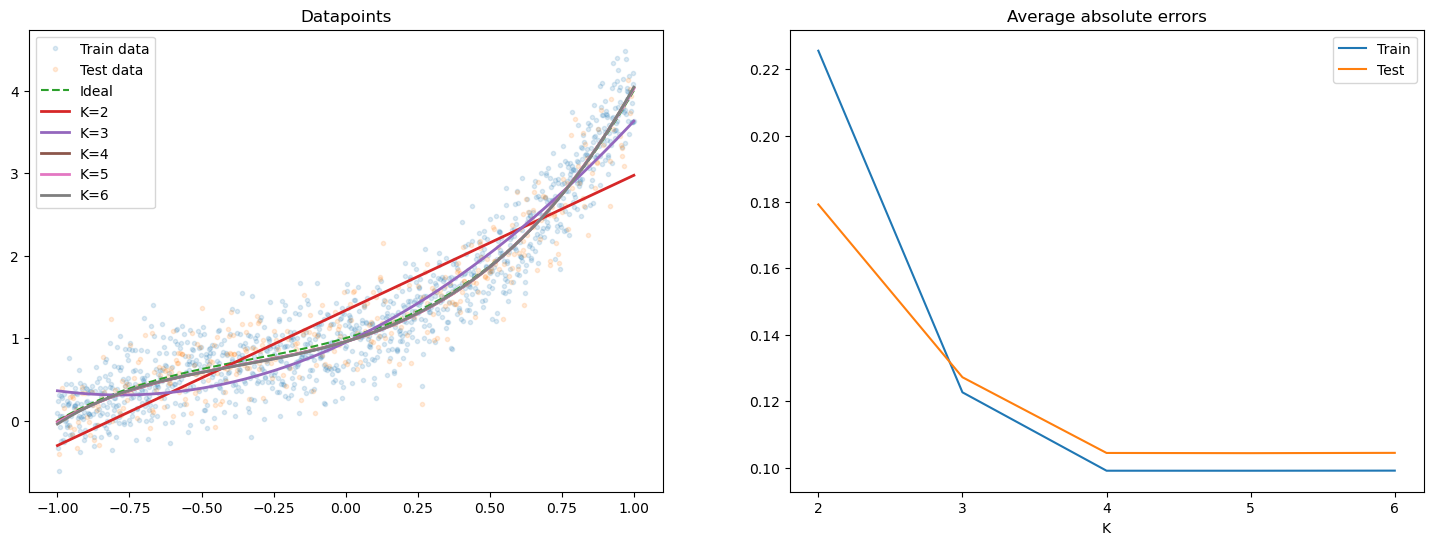

>>>>> lambda = 0.325 <<<<<
K=2 | Avg absolute error: [test] 0.17890868723306225  | [train] 0.2255510894766766  
K=3 | Avg absolute error: [test] 0.12685986888747858  | [train] 0.12275616143972538 
K=4 | Avg absolute error: [test] 0.10418477452458264  | [train] 0.0991218358656342  
K=5 | Avg absolute error: [test] 0.10412849031308868  | [train] 0.09916840133976698 
K=6 | Avg absolute error: [test] 0.10425246588323646  | [train] 0.09923721614369775 


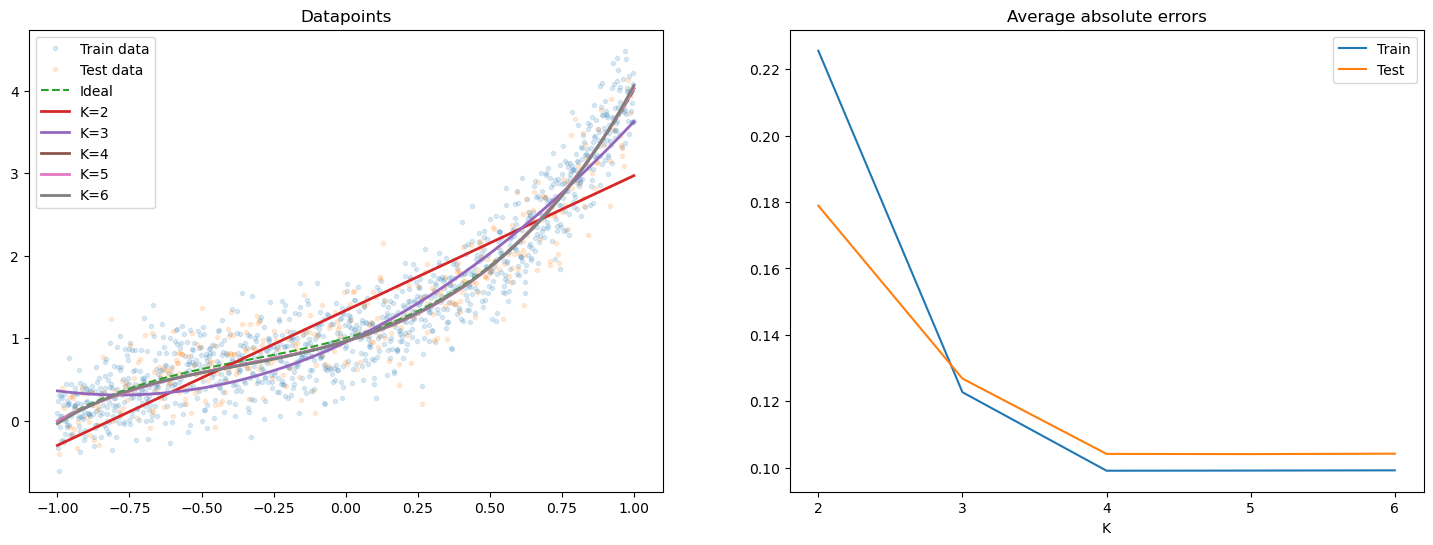

>>>>> lambda = 0.55 <<<<<
K=2 | Avg absolute error: [test] 0.17856822121328814  | [train] 0.22556727677565078 
K=3 | Avg absolute error: [test] 0.1265180907138061   | [train] 0.12285336954692702 
K=4 | Avg absolute error: [test] 0.10396648348958994  | [train] 0.0991911641273839  
K=5 | Avg absolute error: [test] 0.10397321300703133  | [train] 0.09931112851896806 
K=6 | Avg absolute error: [test] 0.1041163787738214   | [train] 0.09939919562968241 


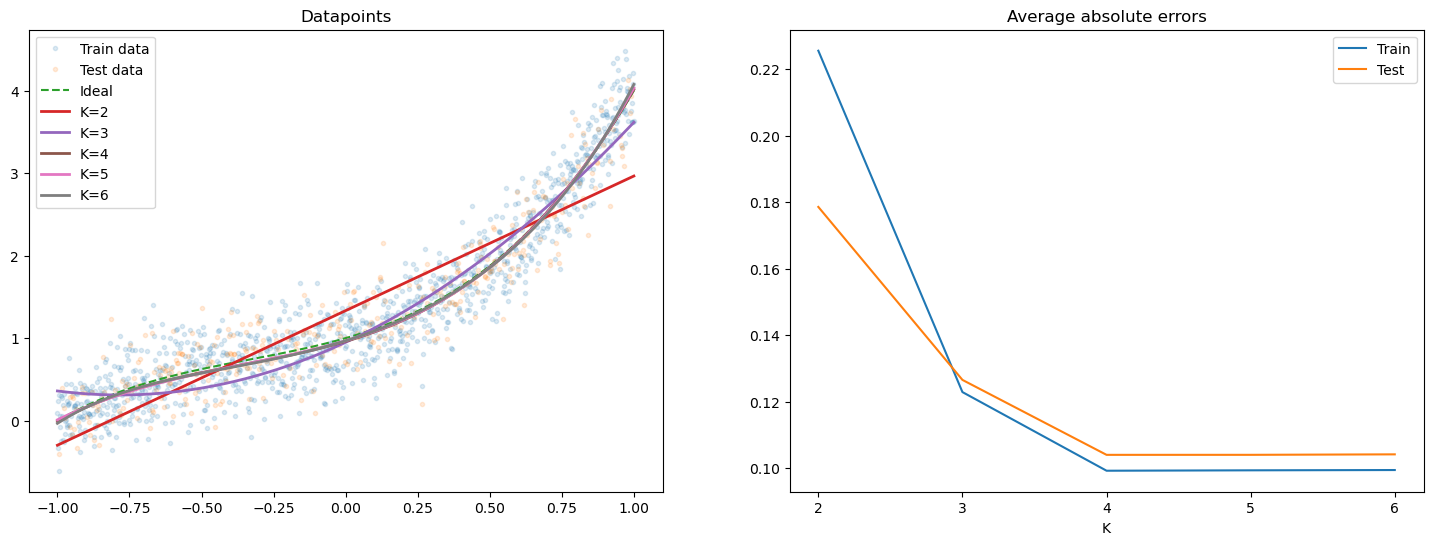

>>>>> lambda = 0.775 <<<<<
K=2 | Avg absolute error: [test] 0.17823809259206397  | [train] 0.22559356319954887 
K=3 | Avg absolute error: [test] 0.12619069766118168  | [train] 0.12296387153982476 
K=4 | Avg absolute error: [test] 0.10376018867051252  | [train] 0.09927358737994627 
K=5 | Avg absolute error: [test] 0.10385657285713991  | [train] 0.09947063147266338 
K=6 | Avg absolute error: [test] 0.10400716116489708  | [train] 0.09956333978829214 


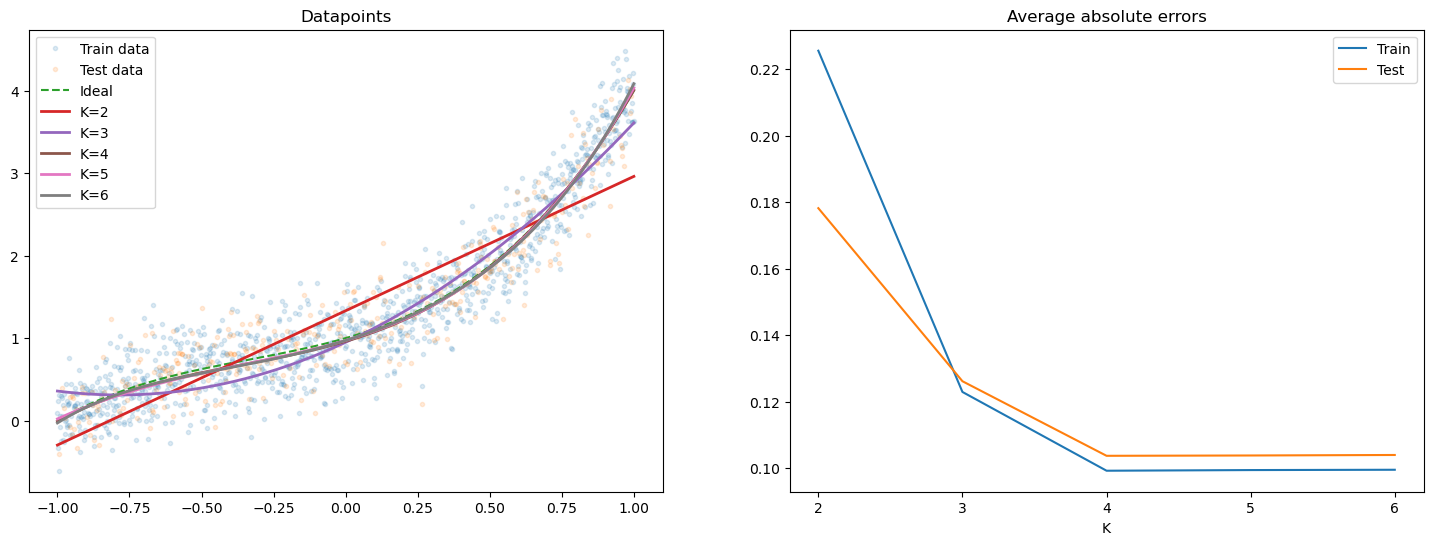

>>>>> lambda = 1.0 <<<<<
K=2 | Avg absolute error: [test] 0.17791823506098278  | [train] 0.22562988071061707 
K=3 | Avg absolute error: [test] 0.12587747506268535  | [train] 0.12308746461218034 
K=4 | Avg absolute error: [test] 0.1035654259102347   | [train] 0.09936849741302466 
K=5 | Avg absolute error: [test] 0.10376299145092756  | [train] 0.09963790592765795 
K=6 | Avg absolute error: [test] 0.10391402372144128  | [train] 0.0997262839603649  


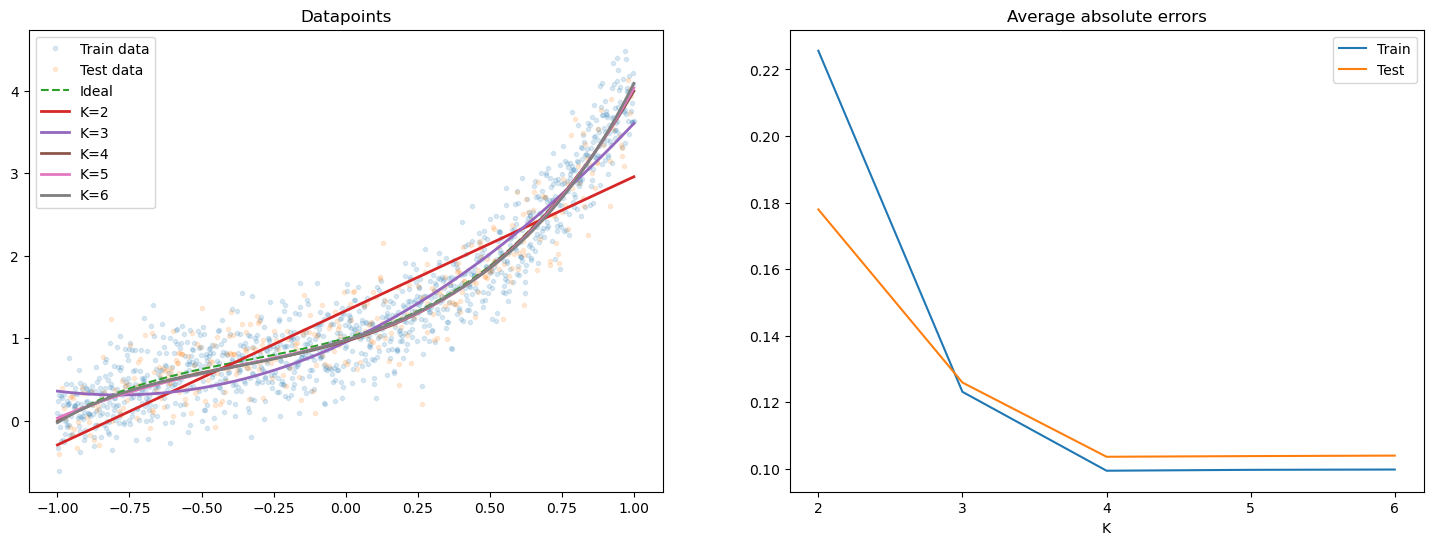

In [10]:
for to_try_lambda in np.linspace(0.1, 1, 5):
    print(f">>>>> lambda = {to_try_lambda} <<<<<")
    plotDataForVaryingK(MAPRegressor(K=None, lamb=to_try_lambda), X_train, Y_train, X_test, Y_test, real_K=K, K_variation=2, fig_size=(18,6), theta_true=theta_true)

### Fixed $K$, varying $\lambda$

In [11]:
def plotDataForVaryingLambda(model, X_train, Y_train, X_test, Y_test, to_try_lambda, real_K, theta_true, fig_size=(18, 6)):
    train_errors = []
    test_errors = []
    plot_X = np.linspace(a, b, 10000)

    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    plt.title("Datapoints")
    plt.plot(X_train, Y_train, ".", alpha=0.15, label="Train data")
    plt.plot(X_test, Y_test, ".", alpha=0.15, label="Test data")
    plt.plot(plot_X, Phi(plot_X, real_K) @ theta_true, "--", label="Ideal")
    
    for lamb in to_try_lambda:
        model.lamb = lamb
        model.fit(X_train, Y_train, epochs=1000)
        train_errors.append( avgAbsoluteError(model, X_train, Y_train) )
        test_errors.append( avgAbsoluteError(model, X_test, Y_test) )

        print(f"Lambda={lamb:.3f} | Avg absolute error: [test] {test_errors[-1]:<20} | [train] {train_errors[-1]:<20}")
        plt.plot(plot_X, model.predict(plot_X), "-", label=f"Lambda={lamb:.3f}", linewidth=2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Average absolute errors")
    plt.plot(to_try_lambda, train_errors, label="Train")
    plt.plot(to_try_lambda, test_errors, label="Test")
    plt.xlabel("Lambda")
    plt.xticks(to_try_lambda)
    plt.legend()
    plt.show()

>>>>> K = 3 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.12721625381705154  | [train] 0.12267245682573238 
Lambda=0.311 | Avg absolute error: [test] 0.12688144265084947  | [train] 0.12275060125541763 
Lambda=0.522 | Avg absolute error: [test] 0.1265595027821944   | [train] 0.12284064506442502 
Lambda=0.733 | Avg absolute error: [test] 0.126250250596396    | [train] 0.12294241458550359 
Lambda=0.944 | Avg absolute error: [test] 0.12595350790808765  | [train] 0.12305574145162156 
Lambda=1.156 | Avg absolute error: [test] 0.12566910174344467  | [train] 0.12318046237779282 
Lambda=1.367 | Avg absolute error: [test] 0.12539686413270515  | [train] 0.12331641895341164 
Lambda=1.578 | Avg absolute error: [test] 0.12513663191244773  | [train] 0.12346345744453253 
Lambda=1.789 | Avg absolute error: [test] 0.12488824653710137  | [train] 0.12362142860555274 
Lambda=2.000 | Avg absolute error: [test] 0.12465155389920127  | [train] 0.12379018749979706 


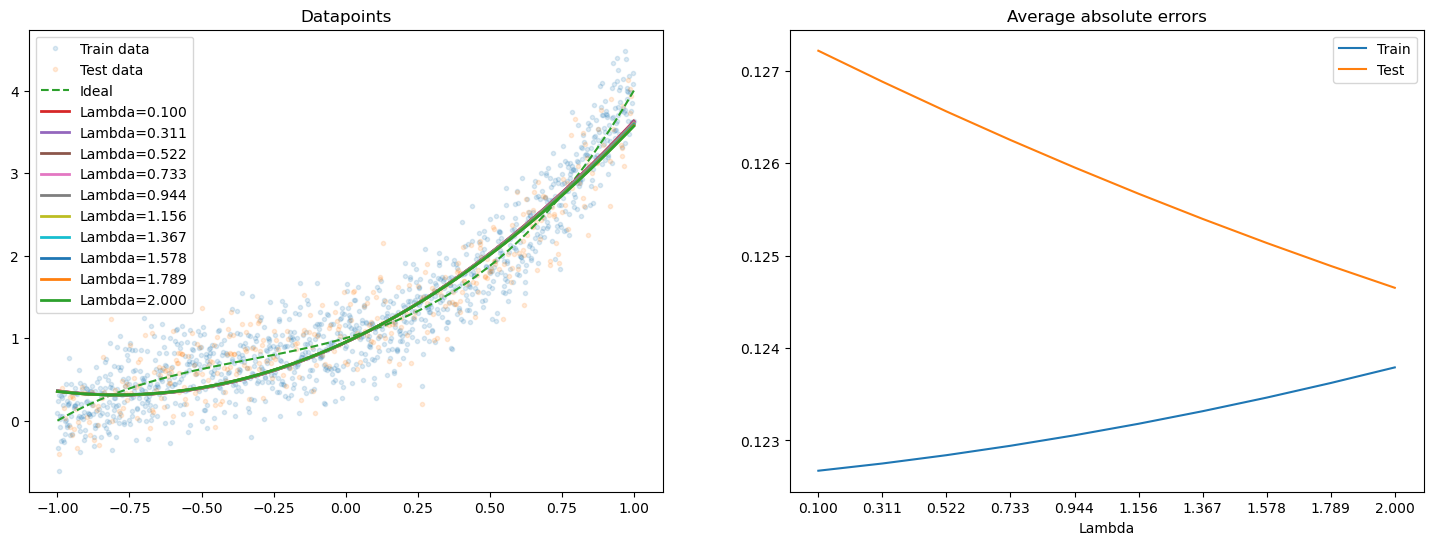

>>>>> K = 5 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.10435517619719217  | [train] 0.09906470917570355 
Lambda=0.311 | Avg absolute error: [test] 0.10413993473971417  | [train] 0.09916052624609367 
Lambda=0.522 | Avg absolute error: [test] 0.10398984934330796  | [train] 0.0992923235228828  
Lambda=0.733 | Avg absolute error: [test] 0.1038761069590105   | [train] 0.09944033952043406 
Lambda=0.944 | Avg absolute error: [test] 0.10378446571243868  | [train] 0.0995961305579581  
Lambda=1.156 | Avg absolute error: [test] 0.10370745663148259  | [train] 0.09975609615300016 
Lambda=1.367 | Avg absolute error: [test] 0.10364098724201459  | [train] 0.09991881361180405 
Lambda=1.578 | Avg absolute error: [test] 0.1035827434587833   | [train] 0.10008386424026912 
Lambda=1.789 | Avg absolute error: [test] 0.1035313896358726   | [train] 0.10025129058325587 
Lambda=2.000 | Avg absolute error: [test] 0.10348614745277118  | [train] 0.10042133710811743 


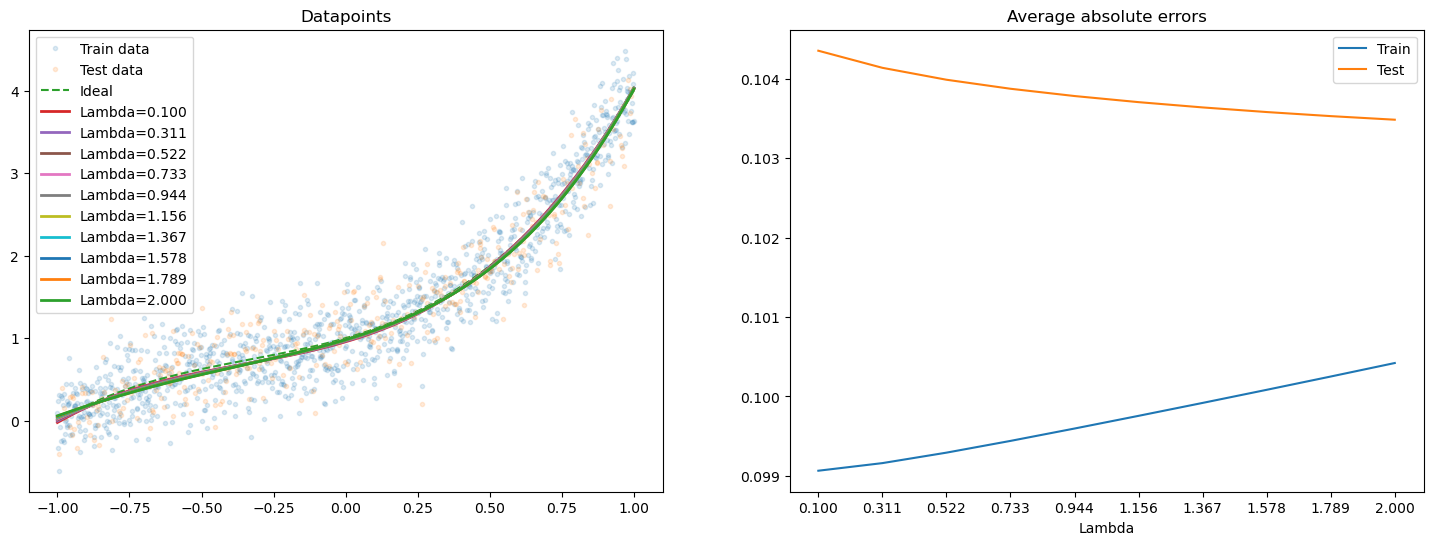

>>>>> K = 24 <<<<<
Lambda=0.100 | Avg absolute error: [test] 0.10467942106687805  | [train] 0.0985056311940556  
Lambda=0.311 | Avg absolute error: [test] 0.10451309462520036  | [train] 0.0987118444108226  
Lambda=0.522 | Avg absolute error: [test] 0.10439019763110895  | [train] 0.09887856311848732 
Lambda=0.733 | Avg absolute error: [test] 0.10428473743000154  | [train] 0.09903180653744245 
Lambda=0.944 | Avg absolute error: [test] 0.10419127847351546  | [train] 0.09918269617807154 
Lambda=1.156 | Avg absolute error: [test] 0.10410806160992327  | [train] 0.099335779582036   
Lambda=1.367 | Avg absolute error: [test] 0.1040343577222782   | [train] 0.09949318028219158 
Lambda=1.578 | Avg absolute error: [test] 0.10396982981872338  | [train] 0.09965604856121824 
Lambda=1.789 | Avg absolute error: [test] 0.10391431392397138  | [train] 0.09982508556049921 
Lambda=2.000 | Avg absolute error: [test] 0.10386772595079224  | [train] 0.10000075392334135 


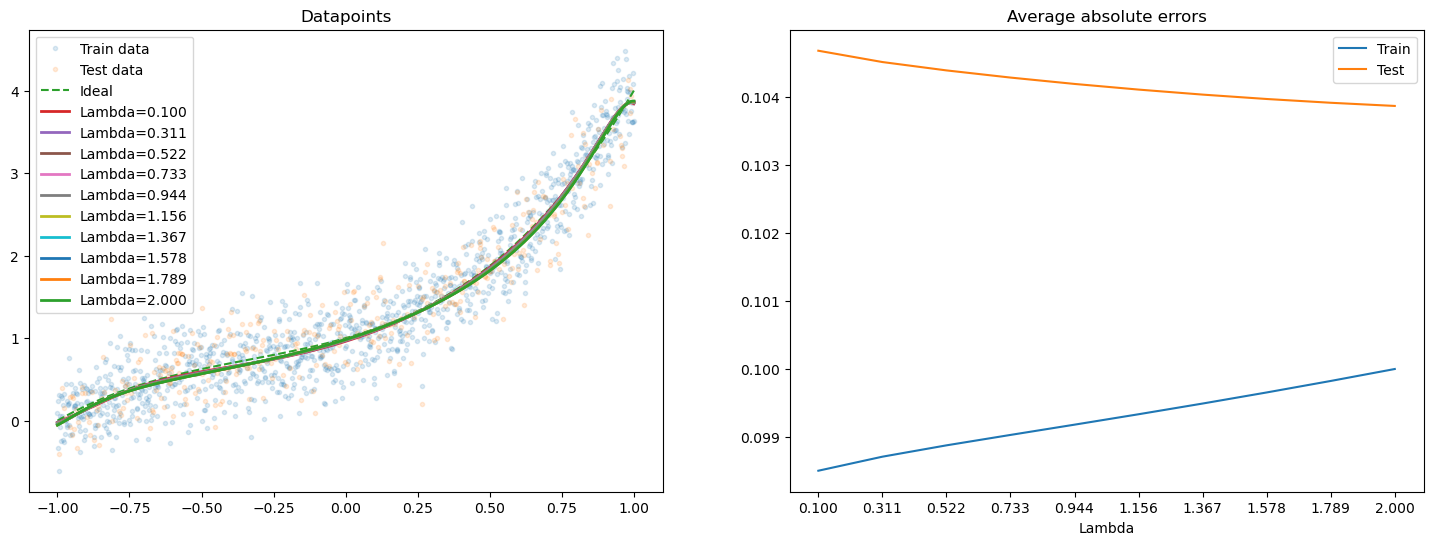

In [12]:
for try_K in [K-1, K+1, K+20]:
    print(f">>>>> K = {try_K} <<<<<")
    plotDataForVaryingLambda(MAPRegressor(K=try_K, lamb=None), X_train, Y_train, X_test, Y_test, to_try_lambda=np.linspace(0.1, 2, 10), real_K=K, theta_true=theta_true)

## MLE vs MAP

### Average absolute error for greater K

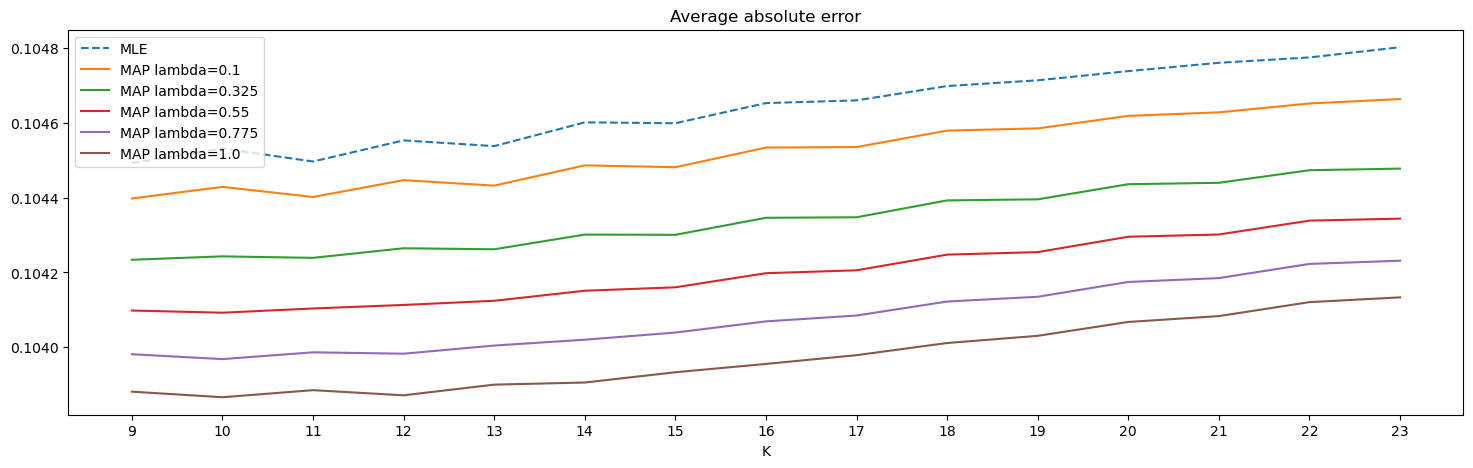

In [13]:
to_try_K = [K+i for i in range(5, 20)]
to_try_lambda = np.linspace(0.1, 1, 5)
mle_abs_errors = []
map_abs_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Theta error for greater K

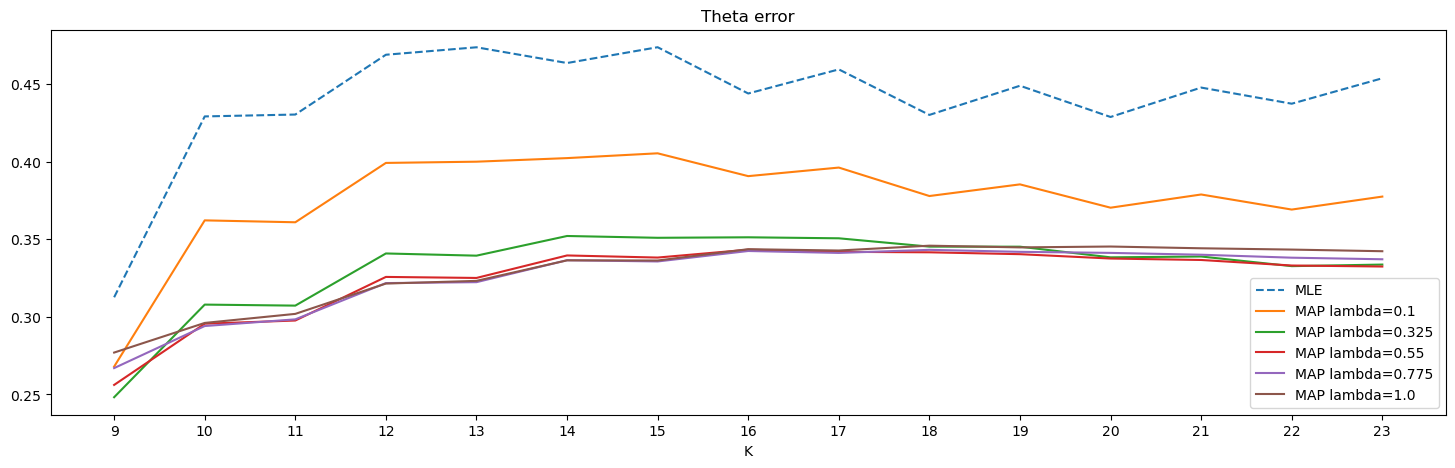

In [14]:
to_try_K = [K+i for i in range(5, 20)]
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_theta_errors = { l: [] for l in to_try_lambda }

for try_K in to_try_K:
    mle_model = MLERegressor(K=try_K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_theta_errors.append( thetaError(mle_model, theta_true) )

    for i, lamb in enumerate(to_try_lambda):
        map_model = MAPRegressor(K=try_K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )

plt.figure(figsize=(18, 5))
plt.plot(to_try_K, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_K, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

### Different number of datapoints with correct K

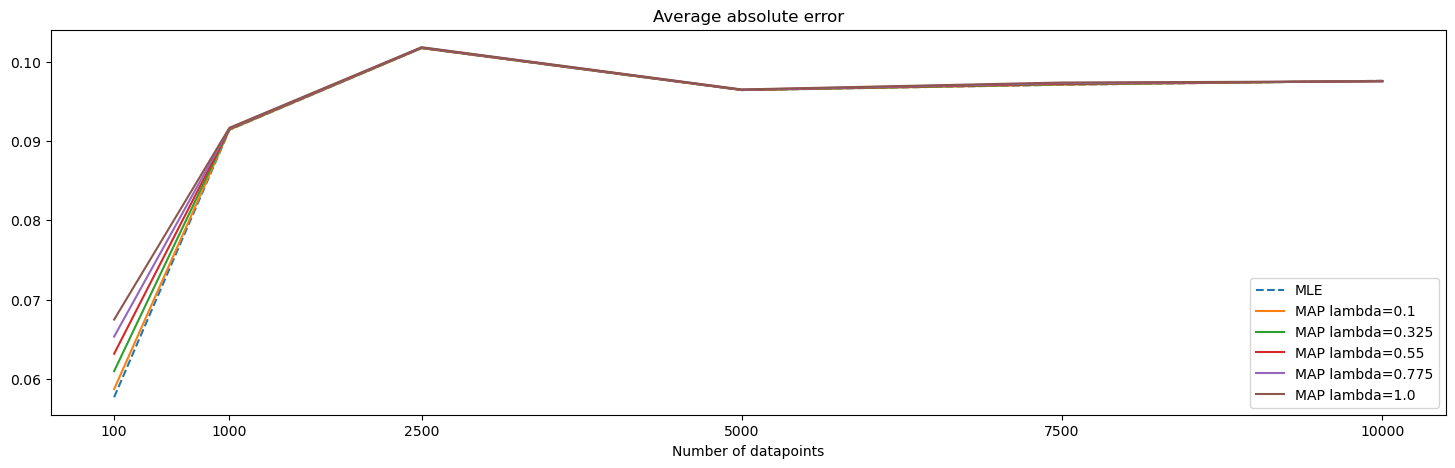

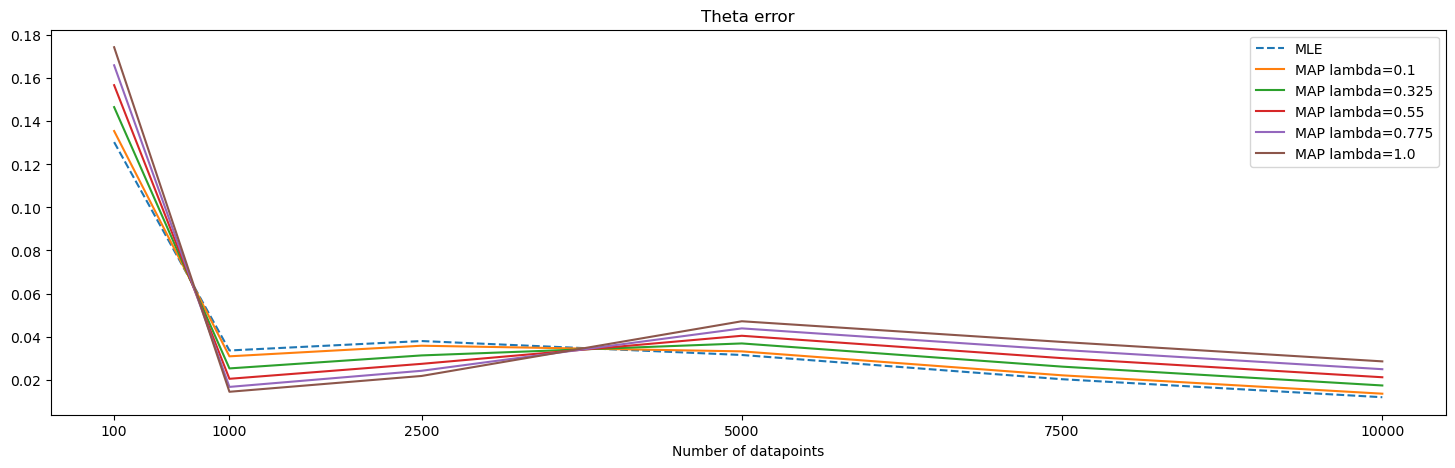

In [15]:
to_try_N = [100, 1000, 2500, 5000, 7500, 10000]
mle_abs_errors = []
mle_theta_errors = []
to_try_lambda = np.linspace(0.1, 1, 5)
map_abs_errors = { l: [] for l in to_try_lambda }
map_theta_errors = { l: [] for l in to_try_lambda }

for try_N in to_try_N:
    X_full, Y_full = createDataset(try_N, a, b, K, theta_true, variance)
    X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

    mle_model = MLERegressor(K=K)
    mle_model.fit(X_train, Y_train, epochs=1000)
    mle_abs_errors.append( avgAbsoluteError(mle_model, X_test, Y_test) )
    mle_theta_errors.append( thetaError(mle_model, theta_true) )
    
    for lamb in to_try_lambda:
        map_model = MAPRegressor(K=K, lamb=lamb)
        map_model.fit(X_train, Y_train, epochs=1000)
        map_abs_errors[lamb].append( avgAbsoluteError(map_model, X_test, Y_test) )
        map_theta_errors[lamb].append( thetaError(map_model, theta_true) )


plt.figure(figsize=(18, 5))
plt.title("Average absolute error")
plt.plot(to_try_N, mle_abs_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_abs_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

plt.figure(figsize=(18, 5))
plt.title("Theta error")
plt.plot(to_try_N, mle_theta_errors, "--", label="MLE")
for lamb in to_try_lambda:
    plt.plot(to_try_N, map_theta_errors[lamb], label=f"MAP lambda={lamb}")
plt.xlabel("Number of datapoints")
plt.xticks(to_try_N)
plt.legend()
plt.show()

### Different optimizers

In [16]:
X_full, Y_full = createDataset(N, a, b, K, theta_true, variance)
X_train, Y_train, X_test, Y_test = train_test_split(X_full, Y_full, int(0.75*X_full.shape[0]))

          |        Theta error        |    Avg absolute error    
MLE (SGD) |       0.0360010414        |       0.1045223970       
MLE (GD)  |       0.0344440943        |       0.1043953234       
MLE (NEQ) |       0.0344331420        |       0.1043951995       
MAP (SGD) |       0.0354971441        |       0.1044156101       
MAP (GD)  |       0.0342646129        |       0.1043585789       
MAP (NEQ) |       0.0342526825        |       0.1043584523       


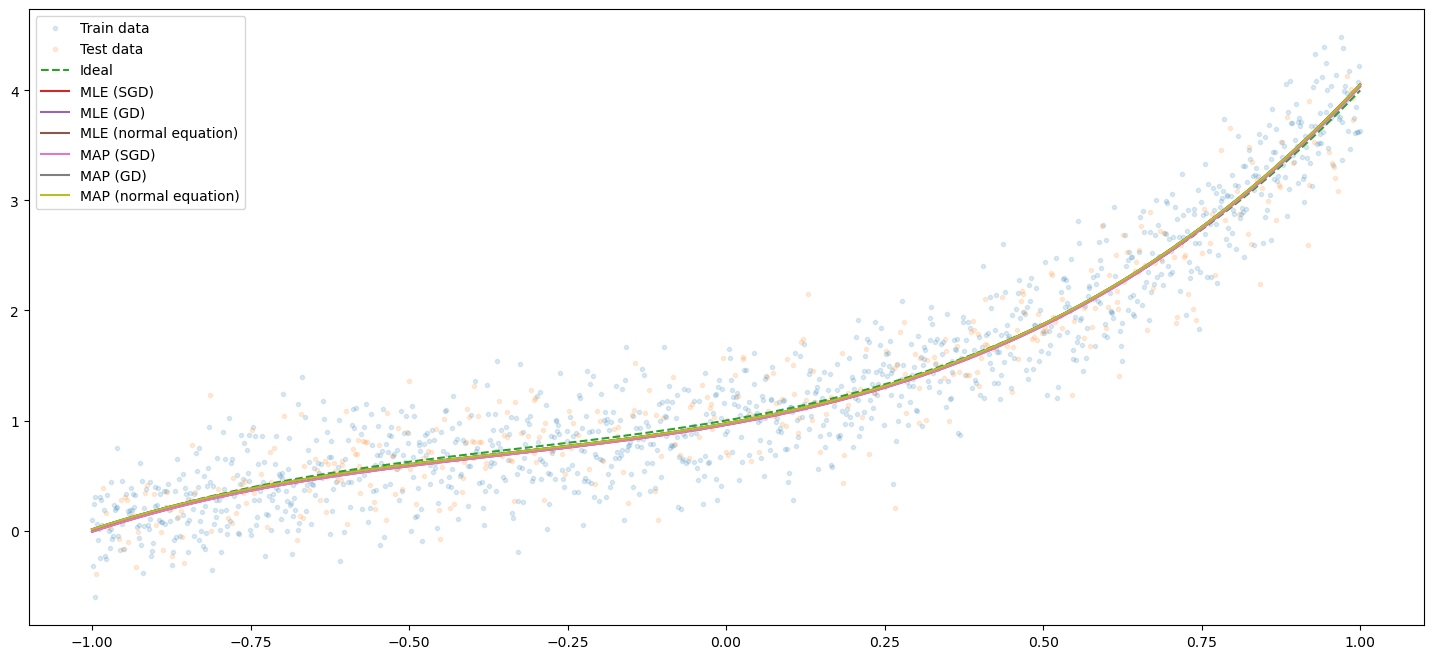

In [17]:
mle_model_sgd = MLERegressor(K=K).fit(X_train, Y_train, epochs=1000)
mle_model_gd = MLERegressor(K=K).fit_gd(X_train, Y_train, epochs=1000)
mle_model_neq = MLERegressor(K=K).fit_neq(X_train, Y_train)
map_model_sgd = MAPRegressor(K=K, lamb=0.1).fit(X_train, Y_train, epochs=1000)
map_model_gd = MAPRegressor(K=K, lamb=0.1).fit_gd(X_train, Y_train, epochs=1000)
map_model_neq = MAPRegressor(K=K, lamb=0.1).fit_neq(X_train, Y_train)


print(f"          | {'Theta error':^25} | {'Avg absolute error':^25}")

print(f"MLE (SGD) | {thetaError(mle_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_sgd, X_test, Y_test):^25.10f}")
print(f"MLE (GD)  | {thetaError(mle_model_gd, theta_true):^25.10f} | {avgAbsoluteError(mle_model_gd, X_test, Y_test):^25.10f}")
print(f"MLE (NEQ) | {thetaError(mle_model_neq, theta_true):^25.10f} | {avgAbsoluteError(mle_model_neq, X_test, Y_test):^25.10f}")

print(f"MAP (SGD) | {thetaError(map_model_sgd, theta_true):^25.10f} | {avgAbsoluteError(map_model_sgd, X_test, Y_test):^25.10f}")
print(f"MAP (GD)  | {thetaError(map_model_gd, theta_true):^25.10f} | {avgAbsoluteError(map_model_gd, X_test, Y_test):^25.10f}")
print(f"MAP (NEQ) | {thetaError(map_model_neq, theta_true):^25.10f} | {avgAbsoluteError(map_model_neq, X_test, Y_test):^25.10f}")


plt.figure(figsize=(18, 8))
plt.plot(X_train, Y_train, ".", alpha=0.15, label="Train data")
plt.plot(X_test, Y_test, ".", alpha=0.15, label="Test data")
plot_X = np.linspace(a, b, 10000)
plt.plot(plot_X, (Phi(plot_X, K) @ theta_true), "--", label="Ideal")
plt.plot(plot_X, mle_model_sgd.predict(plot_X), label="MLE (SGD)")
plt.plot(plot_X, mle_model_gd.predict(plot_X), label="MLE (GD)")
plt.plot(plot_X, mle_model_neq.predict(plot_X), label="MLE (normal equation)")
plt.plot(plot_X, map_model_sgd.predict(plot_X), label="MAP (SGD)")
plt.plot(plot_X, map_model_gd.predict(plot_X), label="MAP (GD)")
plt.plot(plot_X, map_model_neq.predict(plot_X), label="MAP (normal equation)")
plt.legend()
plt.show()

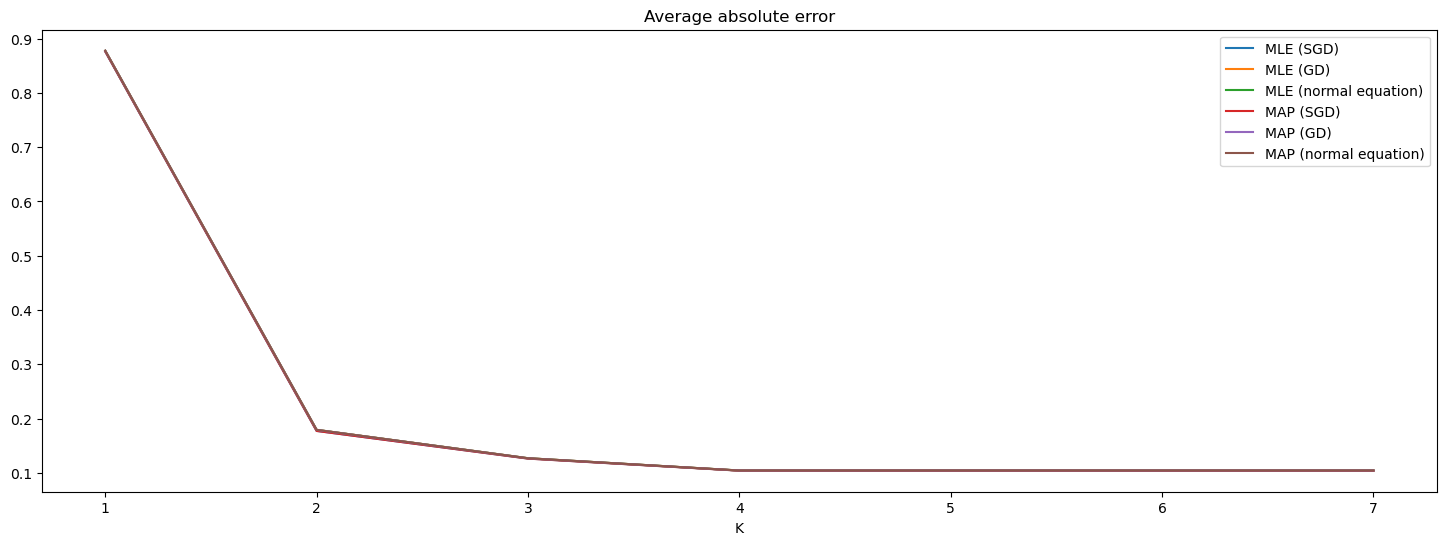

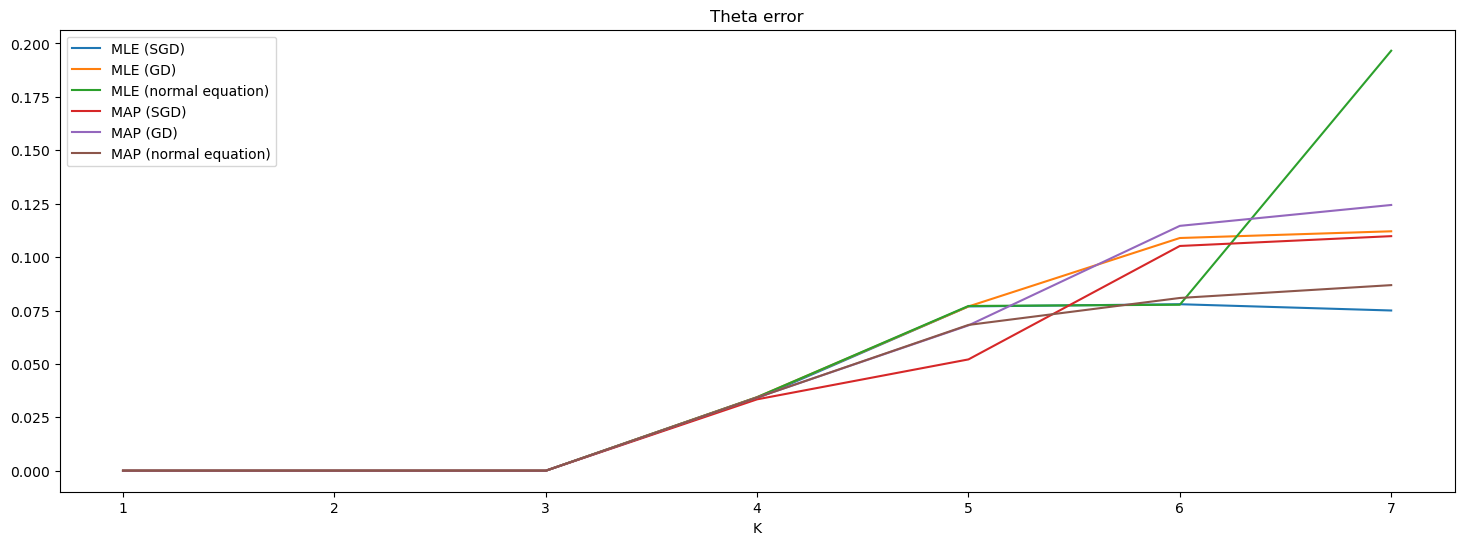

In [18]:
to_try_K = [*range(max(1, K-3), K)] + [K] + [*range(K+1, K+4)]
mle_sgd_abs_errors = []
mle_gd_abs_errors = []
mle_neq_abs_errors = []
map_sgd_abs_errors = []
map_gd_abs_errors = []
map_neq_abs_errors = []
mle_sgd_theta_errors = []
mle_gd_theta_errors = []
mle_neq_theta_errors = []
map_sgd_theta_errors = []
map_gd_theta_errors = []
map_neq_theta_errors = []

for try_K in to_try_K:
    mle_model_sgd = MLERegressor(K=try_K).fit(X_train, Y_train, epochs=2000)
    mle_model_gd = MLERegressor(K=try_K).fit_gd(X_train, Y_train, epochs=2000)
    mle_model_neq = MLERegressor(K=try_K).fit_neq(X_train, Y_train)
    map_model_sgd = MAPRegressor(K=try_K, lamb=0.1).fit(X_train, Y_train, epochs=2000)
    map_model_gd = MAPRegressor(K=try_K, lamb=0.1).fit_gd(X_train, Y_train, epochs=2000)
    map_model_neq = MAPRegressor(K=try_K, lamb=0.1).fit_neq(X_train, Y_train)

    mle_sgd_abs_errors.append( avgAbsoluteError(mle_model_sgd, X_test, Y_test) )
    mle_gd_abs_errors.append( avgAbsoluteError(mle_model_gd, X_test, Y_test) )
    mle_neq_abs_errors.append( avgAbsoluteError(mle_model_neq, X_test, Y_test) )
    map_sgd_abs_errors.append( avgAbsoluteError(map_model_sgd, X_test, Y_test) )
    map_gd_abs_errors.append( avgAbsoluteError(map_model_gd, X_test, Y_test) )
    map_neq_abs_errors.append( avgAbsoluteError(map_model_neq, X_test, Y_test) )
    if try_K >= K:
        mle_sgd_theta_errors.append( thetaError(mle_model_sgd, theta_true) )
        mle_gd_theta_errors.append( thetaError(mle_model_gd, theta_true) )
        mle_neq_theta_errors.append( thetaError(mle_model_neq, theta_true) )
        map_sgd_theta_errors.append( thetaError(map_model_sgd, theta_true) )
        map_gd_theta_errors.append( thetaError(map_model_gd, theta_true) )
        map_neq_theta_errors.append( thetaError(map_model_neq, theta_true) )
    else:
        mle_sgd_theta_errors.append(0)
        mle_gd_theta_errors.append(0)
        mle_neq_theta_errors.append(0)
        map_sgd_theta_errors.append(0)
        map_gd_theta_errors.append(0)
        map_neq_theta_errors.append(0)
    
plt.figure(figsize=(18, 6))
plt.plot(to_try_K, mle_sgd_abs_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_abs_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_abs_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_abs_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_abs_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_abs_errors, label="MAP (normal equation)")
plt.title("Average absolute error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(to_try_K, mle_sgd_theta_errors, label="MLE (SGD)")
plt.plot(to_try_K, mle_gd_theta_errors, label="MLE (GD)")
plt.plot(to_try_K, mle_neq_theta_errors, label="MLE (normal equation)")
plt.plot(to_try_K, map_sgd_theta_errors, label="MAP (SGD)")
plt.plot(to_try_K, map_gd_theta_errors, label="MAP (GD)")
plt.plot(to_try_K, map_neq_theta_errors, label="MAP (normal equation)")
plt.title("Theta error")
plt.xlabel("K")
plt.xticks(to_try_K)
plt.legend()
plt.show()